https://methodmatters.blogspot.com/2017/05/analyzing-wine-data-in-python-part-2.html

### Import necessary libraries 

In [1]:
import numpy                    as np
import pandas                   as pd
import seaborn                  as sns
import timeit

from   sklearn.cross_validation import  train_test_split
from   sklearn.metrics          import  make_scorer
from   sklearn.ensemble         import  RandomForestClassifier

from   sklearn                  import  metrics 
from   sklearn.metrics          import  classification_report
from   sklearn.metrics          import  confusion_matrix, accuracy_score
from   sklearn.metrics          import  roc_curve, auc

from   sklearn.model_selection  import  ParameterGrid, cross_val_score
from   sklearn.grid_search      import  GridSearchCV, RandomizedSearchCV
from   scipy.stats              import  randint, uniform

from hyperopt import hp, tpe, fmin, STATUS_OK, Trials

import matplotlib.pyplot        as plt

# Pretty display for notebooks
%matplotlib inline

D:\Python\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Python\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
D:\Python\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
data_url = 'http://mlr.cs.umass.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data_df  = pd.read_csv(data_url, sep=';')

In [3]:
print(data_df.shape)
print(data_df.columns)

(1599, 12)
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


In [4]:
data_df['quality'] = data_df['quality'].astype('category') 

In [5]:
data_df['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

We observe that there are a lot of wines with a quality of 5 as compared to the others. The dataset description states – there are a lot more normal wines than excellent or poor ones. For the purpose of this discussion, let’s classify the wines into good, bad, and normal based on their quality.

In [6]:
data_df['wine_quality']  = data_df['quality'].\
                               apply(lambda x: 'Bad' if x < 6 \
                                     else 'Good')

In [7]:
y        = data_df.wine_quality # Create the response variable data
X        = data_df.drop(['quality','wine_quality'], axis=1) # create predictor variables data

In [8]:
y.value_counts()

Good    855
Bad     744
Name: wine_quality, dtype: int64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.34, stratify = y)

In [10]:
print('training data X: shape ', X_train.shape)
print('training data y: shape ', y_train.shape)
print('test data X: shape ',     X_test.shape)
print('test data y: shape ',     y_test.shape)

training data X: shape  (1055, 11)
training data y: shape  (1055,)
test data X: shape  (544, 11)
test data y: shape  (544,)


In [11]:
print('\nY train\n', y_train.value_counts())
print('\nY test\n', y_test.value_counts())


Y train
 Good    564
Bad     491
Name: wine_quality, dtype: int64

Y test
 Good    291
Bad     253
Name: wine_quality, dtype: int64


In [12]:
def draw_cm(cm):
    print(cm)
    import matplotlib.pyplot as   plt
    import sklearn.metrics   as   metrics
    import seaborn           as   sns
    
    sns.heatmap(cm, annot=True, fmt='.2f', \
                xticklabels = ["Bad", "Good"] , yticklabels = ["Bad", "Good"] )
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()   

In [13]:
def objective(params):
    clf         =   RandomForestClassifier(**params)
    loss        =   1- cross_val_score(clf, X_train, y_train, scoring = 'accuracy').mean()
    return {'loss': loss, 'status': STATUS_OK}

In [14]:
p_space = {
        'max_depth':         hp.choice('max_depth', list(range(1, 21))),
        'min_samples_split': hp.choice('min_samples_split', [2, 3, 4, 5])
}

In [15]:
tpe_trials = Trials()
best       = %time fmin(objective, p_space, algo = tpe.suggest, max_evals = 10, trials = tpe_trials)

100%|██████████████████████████████████████████████████| 10/10 [00:00<00:00, 19.58it/s, best loss: 0.22370877579210902]
Wall time: 524 ms


In [16]:
# Dataframe of results from optimization
tpe_results = pd.DataFrame({'loss': [x['loss'] for x in tpe_trials.results], 
                            'iteration': tpe_trials.idxs_vals[0]['max_depth'],
                            'max_depth': tpe_trials.idxs_vals[1]['max_depth'],
                            'min_samples_split': tpe_trials.idxs_vals[1]['min_samples_split']})

tpe_final   = tpe_results.loc[tpe_results['min_samples_split'] > 1 &  (tpe_results['max_depth'] > 0)]
tpe_final   = tpe_final.drop_duplicates(['max_depth','min_samples_split'], keep = 'first')
tpe_final.sort_values(by = 'loss', inplace = True, ascending = True)                          
tpe_final.head()

,loss,iteration,max_depth,min_samples_split
2,0.223709,2,17,2
7,0.229415,7,15,3
4,0.231263,4,19,3
6,0.234152,6,8,3
0,0.250246,0,6,2


In [17]:
bayesian_model =   RandomForestClassifier(max_depth = 17, min_samples_split = 2, \
                                          random_state = 0).\
                                          fit(X_train, y_train)
y_pred         =   bayesian_model.predict(X_test)

[[206  47]
 [ 75 216]]


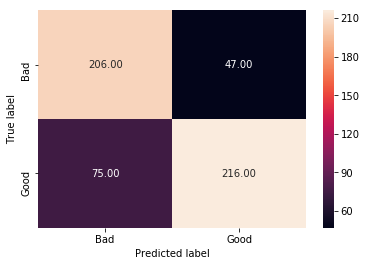

0.7757352941176471
             precision    recall  f1-score   support

        Bad       0.73      0.81      0.77       253
       Good       0.82      0.74      0.78       291

avg / total       0.78      0.78      0.78       544



In [18]:
cm = confusion_matrix(y_test, y_pred)
draw_cm(cm)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))